In [24]:
# =======================
# Load the MNIST handwritten digit dataset and return DataLoaders for training and testing.
# Each image is converted to a PyTorch tensor and normalized to the [0, 1] range.
# DataLoaders enable efficient batching, shuffling, and iteration during training.
# =======================
from torchvision import datasets, transforms # Import MNIST dataset and image transforms
from torch.utils.data import DataLoader # For batching and loading the dataset

def get_mnist_loaders(batch_size=128):

  # Convert images to PyTorch tensors with values scaled to [0, 1]
  transform = transforms.ToTensor()

  # Download and load the training dataset
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

  # Download and load the test dataset
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Wrap datasets in DataLoaders to enable batching and shuffling
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


In [25]:
# =======================
# Visualize a batch of MNIST digit images from the training dataset.
# This function loads a mini-batch using get_mnist_loaders() and displays the digits with their labels.
# Useful for quickly inspecting the raw input data before training.
# =======================
import matplotlib.pyplot as plt # For plotting and displaying images
def visualize_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

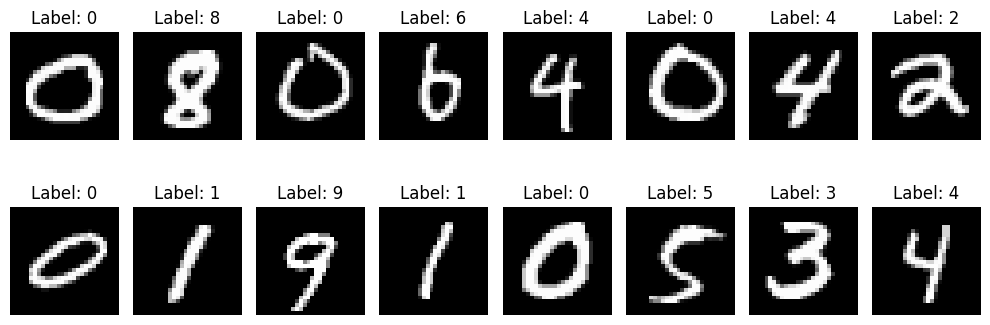

In [26]:
visualize_batch()

In [27]:
# =======================
# Define a fully-connected Autoencoder for compressing and reconstructing MNIST digit images.
# Architecture:
#   Encoder: 784 → 128 → 32
#   Decoder: 32 → 128 → 784
# The model learns to compress 28x28 images into a 32-dimensional latent space and reconstruct them.
# =======================
import torch
import torch.nn as nn
class VAE(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=128, latent_dim=32):
    super().__init__()

    # Encoder layers
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim,  latent_dim) # the mean
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim) # the log of the variance

    # Decoder layers
    self.fc3 = nn.Linear(latent_dim, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, input_dim)

  def encode(self, x):
    h1 = torch.relu(self.fc1(x))
    return self.fc_mu(h1), self.fc_logvar(h1)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    z = mu + eps*std
    return z

  def decode(self, z):
    h3 = torch.relu(self.fc3(z))
    return torch.sigmoid(self.fc4(h3))

  def forward(self, x):
    x = x.view(x.size(0), -1) # Flatten image: [batch, 1, 28, 28] -> [batch, 784]
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    out = self.decode(z) # Decode back to reconstructed image
    return out, mu, logvar

In [28]:
train_loader, test_loader = get_mnist_loaders()

In [29]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE()
model.to(device)

VAE(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
)

In [30]:
import torch.nn.functional as F
def loss_function(recon_x, x, mu, logvar):
  bce_loss = F.binary_cross_entropy(recon_x, x.view(x.size(0), -1), reduction='sum')

  # KL Divergence
  kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  # Normalize both terms by batch size (per-sample average)
  batch_size = x.size(0)
  loss = (bce_loss + kld) / batch_size

  return loss

In [31]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
# Train model
epochs = 10
for epoch in range(epochs):
  running_loss = 0.0
  for data in train_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    optim.zero_grad()
    outputs, mu, logvar = model(inputs)
    loss = loss_function(outputs, inputs, mu, logvar)
    loss.backward()
    optim.step()
    running_loss += loss.item()
  print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 193.2529
Epoch 2/10, Loss: 141.5911
Epoch 3/10, Loss: 128.7490
Epoch 4/10, Loss: 122.4878
Epoch 5/10, Loss: 118.5537
Epoch 6/10, Loss: 115.9418
Epoch 7/10, Loss: 114.2570
Epoch 8/10, Loss: 113.0838
Epoch 9/10, Loss: 112.2591
Epoch 10/10, Loss: 111.6781


In [33]:
# Test model
model.eval()
with torch.no_grad():
  test_loss = 0.0
  for data in test_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    outputs, mu, logvar = model(inputs)
    loss = loss_function(outputs, inputs, mu, logvar)
    test_loss += loss.item()
  print(f'Test Loss: {test_loss / len(test_loader)}')


Test Loss: 110.1176515410218


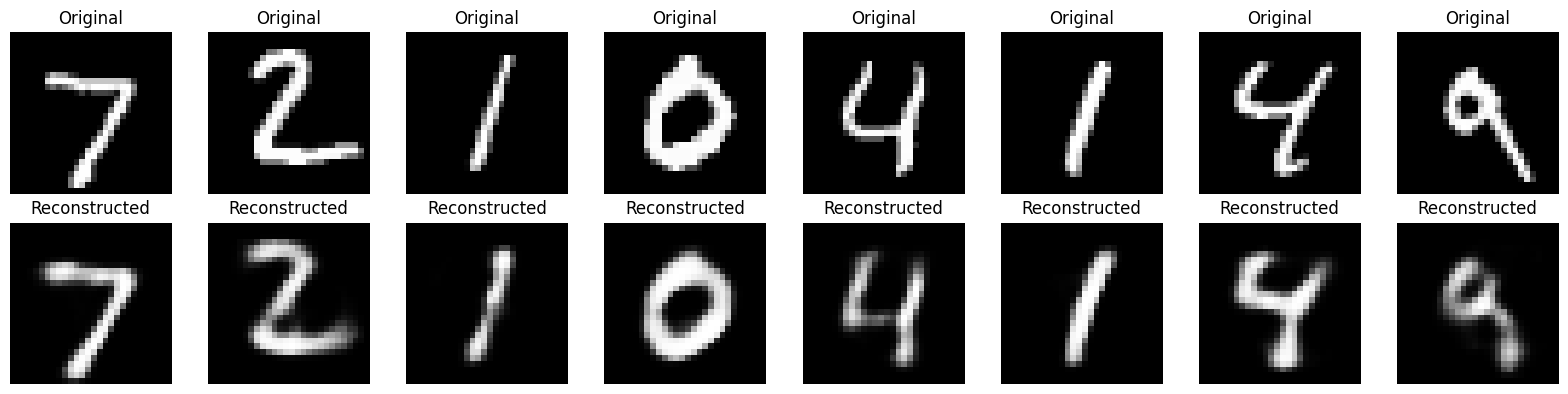

In [34]:
# Visualize reconstruciton
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs = sample_imgs.to(device)
    reconstructed, _, _ = model(sample_imgs)

# Plot original vs reconstructed
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(sample_imgs[i][0].cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].view(28, 28).cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

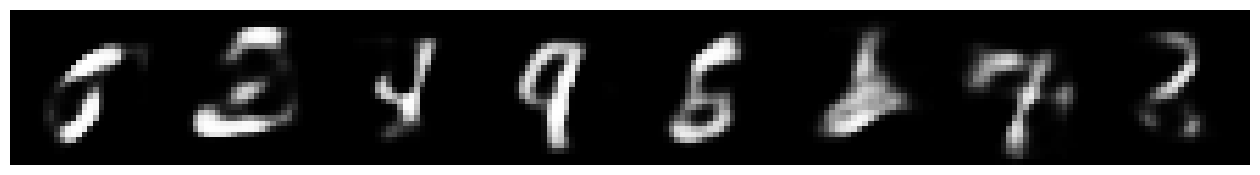

In [42]:
# Generating new samples
import torch
import matplotlib.pyplot as plt

# Set to eval mode and disable gradients
model.eval()
with torch.no_grad():
    # Sample z ~ N(0, I)
    z = torch.randn(8, 32).to(device)  # 8 samples

    # Decode z to x
    generated = model.decode(z)  # Output is (batch_size, 1, 28, 28) or (batch_size, 784)

    # Reshape if needed
    if generated.shape[-1] == 784:
        generated = generated.view(-1, 1, 28, 28)

    # Plot samples
    plt.figure(figsize=(16, 4))
    grid = torch.cat([img for img in generated.cpu()], dim=2).squeeze()
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()
